We want a metric that is:
- **invariant** to the scale of the data
- **invariant** to the location of the data
- **reproducible** (i.e. always gives the same result for the same data)
- **differentiable** (i.e. we can compute the gradient of the metric with respect to the data)
- **deterministic** (i.e. we can compute the metric without sampling)

In [146]:
import os
import configparser
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import scipy
import time
from toolbox.printing import debug
from skimage.measure import label
from typing import Dict, List, Tuple, Optional, Union
import torch
import torch.nn.functional as F
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import cv2
from scipy.interpolate import interp1d

In [147]:
crack_idx = 54
path_image = f"datasets/cracks/cropped/val/images/{crack_idx}.png"
path_mask = f"datasets/cracks/cropped/val/masks/{crack_idx}.png"

In [148]:
def minpool(img: torch.Tensor, size: Tuple[int, int], stride: Tuple[int, int], padding: Tuple[int, int]) -> torch.Tensor:
    """Minpooling function.
    
    Args:
        img: Input image.
        **kwargs: Keyword arguments for F.max_pool2d.
        
    Returns:
        Minpooled image.
    """
    return -F.max_pool2d(-img, size, stride, padding)

# Source: https://github.com/jocpae/clDice/blob/master/cldice_loss/pytorch/soft_skeleton.py
def soft_erode(img: torch.Tensor) -> torch.Tensor:
    """Soft erosion function.

    This function is a soft approximation of the erosion operator. It is
    defined as a minpooling between a pixel and its direct neighbors (cross pattern).
    It is a differentiable approximation of the erosion operator.

    Args:
        img: Input image.
    
    Returns:
        Eroded image.
    """
    p1 = minpool(img, (3,1), (1,1), (1,0))
    p2 = minpool(img, (1,3), (1,1), (0,1))
    return torch.min(p1,p2)


# Source: https://github.com/jocpae/clDice/blob/master/cldice_loss/pytorch/soft_skeleton.py
def soft_dilate(img: torch.Tensor) -> torch.Tensor:
    """Soft dilation function.

    This function is a soft approximation of the dilation operator. It is
    defined as a maxpooling between a pixel and its direct neighbors (cross pattern).
    It is a differentiable approximation of the dilation operator.

    Args:
        img: Input image.
    
    Returns:
        Dilated image.
    """
    p1 = F.max_pool2d(img, (3,1), (1,1), (1,0))
    p2 = F.max_pool2d(img, (1,3), (1,1), (0,1))
    return torch.max(p1,p2)


# Source: https://github.com/jocpae/clDice/blob/master/cldice_loss/pytorch/soft_skeleton.py
def soft_open(img: torch.Tensor) -> torch.Tensor:
    """Soft opening function.
    
    Args:
        img: Input image.
        
    Returns:
        Opened image.
    """
    return soft_dilate(soft_erode(img))


# Source: https://github.com/jocpae/clDice/blob/master/cldice_loss/pytorch/soft_skeleton.py
def soft_skeletonize(img: torch.Tensor, iter_: int = 10) -> torch.Tensor:
    """Soft skeletonization function.

    This function is a soft approximation of the morphological skeletonization operator.
    It is defined as the successive application of soft erosion and soft opening.
    The number of iterations should be greater than the largest diameter of the objects
    in the image.

    Args:
        img: Input image.
        iter_: Number of iterations.

    Returns:
        Skeletonized image.
    """
    img1  =  soft_open(img)
    skel  =  F.relu(img-img1)
    for j in range(iter_):
        img  =  soft_erode(img)
        img1  =  soft_open(img)
        delta  =  F.relu(img-img1)
        skel  =  skel +  F.relu(delta-skel*delta)
    return skel

In [149]:
def max_minpool_thin(T: torch.Tensor, left: bool = True) -> torch.Tensor:
    """Max-minpooling thinning function.

    This version uses a kernel of size 2x2 instead of 3x3.
    This is technically not possible due to padding issues, but we can
    circumvent this by using a maxpooling of size 2x2 with stride 1 and
    padding 1, followed by a minpooling of size 2x2 with stride 1 and
    padding 0 (for left thinning) or 1 (for right thinning).
    This introduces a bias towards the left or right, but this is not
    a problem for our application.
    
    Args:
        T: Input image.
        left: Whether to use left or right thinning.
        
    Returns:
        Thinned image.
    """
    T = - torch.nn.MaxPool2d(2, stride=1, padding=int(left))(-T)
    T = torch.nn.MaxPool2d(2, stride=1, padding=1-int(left))(T)
    return T

def maxpool_thin(T: torch.Tensor, left: bool = True) -> torch.Tensor:
    """Maxpooling thinning function.

    This version uses a kernel of size 2x2 instead of 3x3.
    Similarly to max_minpool_thin, ww crop the image to the correct size.
    This introduces a bias towards the left or right, but this is not
    a problem for our application.
    
    Args:
        T: Input image.
        left: Whether to use left or right thinning.
        
    Returns:
        Thinned image.
    """
    # T is of shape (H, W)
    T = torch.nn.MaxPool2d(2, stride=1, padding=1)(T)
    # T is now of shape (H+1, W+1)
    if left:
        T = T[:,:-1, :-1]
    else:
        T = T[:,1:, 1:]
    return T

def soft_skeletonize_thin(I: torch.Tensor, k: int) -> torch.Tensor:
    """Soft skeletonization.

    Thinner version of soft_skeletonize.
    This version uses a kernel of size 2x2 instead of 3x3.
    It introduces a bias towards the left or right, but this is not
    a problem for our application.

    Args:
        I: Input image.
        k: Number of iterations.

    Returns:
        Skeletonized image.
    """
    relu = torch.nn.ReLU()
    Ip = max_minpool_thin(I, left = True)
    S = relu(I - Ip)
    for i in range(k):
        I = -maxpool_thin(-I, left = (i%2 == 0))
        Ip = max_minpool_thin(I, left = (i%2 == 0))
        S += (1 - S) * relu(I - Ip)
    return S

In [150]:
def add_smooth_border_to_mask(mask: torch.Tensor, border_size: int = 25, sigma: float = 10.0) -> torch.Tensor:
    """Add a smooth border to a mask.
    
    The input mask should be binary.
    The output mask will be equal to 1 where the input mask is equal to 1.
    Then pixels at a distance d <= border_size from the input mask will have
    a value roughly equal to exp(-d**2 / (2*sigma**2)).
    The distance is computed with the soft_dilate function, which is
    approximate but differentiable.
    
    Args:
        mask: Input mask.
        border_size: Border size.
        sigma: Sigma of the Gaussian function.
        
    Returns:
        Mask with smooth border.
    """

    enlarged_mask = mask.clone()
    expanded_mask = mask.clone()
    for d in range(border_size):
        new_enlarged_mask = soft_dilate(enlarged_mask)
        border: torch.Tensor = (new_enlarged_mask - enlarged_mask)
        expanded_mask = torch.where(border==1, torch.exp(-border * (d+1)**2 / (2*sigma**2)), expanded_mask)
        enlarged_mask = new_enlarged_mask

    return expanded_mask


def soft_dice(ground_truth: torch.Tensor, prediction: torch.Tensor, epsilon: float = 1e-6) -> torch.Tensor:
    """Soft dice.
    
    Args:
        ground_truth: Ground truth mask of shape (H, W) or (N, H, W).
        prediction: Predicted mask of shape (H, W) or (N, H, W).
        epsilon: Epsilon used for numerical stability.
        
    Returns:
        Soft dice.
    """
    numerator = 2. * torch.sum(ground_truth * prediction, dim=(-2, -1))
    denominator = torch.sum(ground_truth**2, dim=(-2, -1)) + torch.sum(prediction**2, dim=(-2, -1))
    return (numerator + epsilon) / (denominator + epsilon)


def smooth_skeleton_dice_loss(ground_truth: torch.Tensor, prediction: torch.Tensor, iterations: int = 10,
                         border_size: int = 25, sigma: float = 10.0, thinner: bool = False) -> torch.Tensor:
    """Smooth skeleton loss.

    Uses the smooth skeletonization function to compute the skeleton of the
    ground truth and predicted masks. Then computes the DICE between the two
    smoothly enlarged skeletons (with add_smooth_border_to_mask)
    
    Args:
        ground_truth: Ground truth mask.
        prediction: Predicted mask.
        iterations: Number of iterations for the soft skeletonization.
        border_size: Border size.
        sigma: Sigma of the Gaussian function.
        
    Returns:
        Smooth skeleton loss.
    """
    if thinner:
        ground_truth_skeleton = soft_skeletonize_thin(ground_truth, iterations)
        prediction_skeleton = soft_skeletonize_thin(prediction, iterations)
    else:
        ground_truth_skeleton = soft_skeletonize(ground_truth, iterations)
        prediction_skeleton = soft_skeletonize(prediction, iterations)
    ground_truth_border = add_smooth_border_to_mask(ground_truth_skeleton, border_size, sigma)
    prediction_border = add_smooth_border_to_mask(prediction_skeleton, border_size, sigma)
    return 1 - soft_dice(ground_truth_border, prediction_border)


def smooth_skeleton_intersection_loss(ground_truth: torch.Tensor, prediction: torch.Tensor, iterations: int = 10,
                         border_size: int = 25, sigma: float = 10.0, thinner: bool = False, epsilon: float = 1e-6) -> torch.Tensor:
    """Smooth skeleton loss.

    Uses the smooth skeletonization function to compute the skeleton of the
    ground truth and predicted masks. Then computes the product between the
    predicted skeleton and the ground truth skeleton enlarged and vice versa.
    
    Args:
        ground_truth: Ground truth mask.
        prediction: Predicted mask.
        iterations: Number of iterations for the soft skeletonization.
        border_size: Border size.
        sigma: Sigma of the Gaussian function.
        
    Returns:
        Smooth skeleton loss.
    """
    if thinner:
        ground_truth_skeleton = soft_skeletonize_thin(ground_truth, iterations)
        prediction_skeleton = soft_skeletonize_thin(prediction, iterations)
    else:
        ground_truth_skeleton = soft_skeletonize(ground_truth, iterations)
        prediction_skeleton = soft_skeletonize(prediction, iterations)
    ground_truth_border = add_smooth_border_to_mask(ground_truth_skeleton, border_size, sigma)
    prediction_border = add_smooth_border_to_mask(prediction_skeleton, border_size, sigma)

    p1_num = torch.sum(ground_truth_border * prediction_skeleton, dim=(-2, -1))
    p1_den = torch.sum(prediction_skeleton, dim=(-2, -1))
    p1 = (p1_num + epsilon) / (p1_den + epsilon)

    p2_num = torch.sum(prediction_border * ground_truth_skeleton, dim=(-2, -1))
    p2_den = torch.sum(ground_truth_skeleton, dim=(-2, -1))
    p2 = (p2_num + epsilon) / (p2_den + epsilon)

    return 1 - torch.sqrt(p1 * p2)

In [151]:
# Load image and mask and converts them to numpy arrays
image = Image.open(path_image)
mask = Image.open(path_mask)
image = np.array(image)
mask = np.array(mask)

In [152]:
debug(mask)
debug(np.max(mask))

DEBUG: mask (ndarray: uint8) = [[0, 0, 0, 0, 0, 0, 0, 0, ....], ...] (128, 128)
DEBUG: np.max(mask (uint8) = 1


In [153]:
def show_mask(mask: np.ndarray, title: Optional[str] = None):
    assert len(mask.shape) == 2, "The mask must be a 2D array"
    # assert mask.dtype == bool or (mask.dtype == np.uint8 or mask.dtype == np.int64) and np.max(mask) <= 1, "The mask must be a boolean array"
    plt.imshow(mask)
    if title is not None:
        plt.title(title)
    plt.show()

def show_image(image: np.ndarray):
    assert len(image.shape) == 3, "The image must be a 3D array"
    assert image.dtype == np.uint8, "The image must be a uint8 array"
    assert image.shape[2] == 3, "The image must have 3 channels positioned in the last dimension"
    plt.imshow(image)
    plt.show()

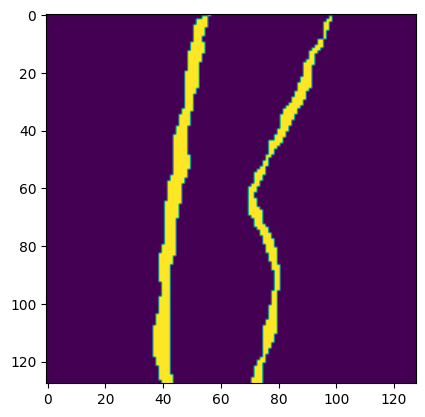

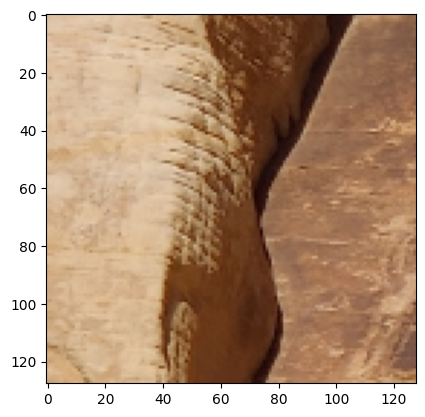

In [154]:
show_mask(mask)
show_image(image)

In [155]:
def separate_mask(mask: np.ndarray):
    assert len(mask.shape) == 2, "The mask must be a 2D array"
    assert mask.dtype == bool or (mask.dtype == np.uint8 or mask.dtype == np.int64) and np.max(mask) <= 1, "The mask must be a boolean array"
    
    separated_mask = label(mask)
    blobs = []
    for i in np.unique(separated_mask):
        if i == 0:  # background
            continue
        blobs.append((separated_mask == i).astype(int))
    return blobs

Found 2 connected components


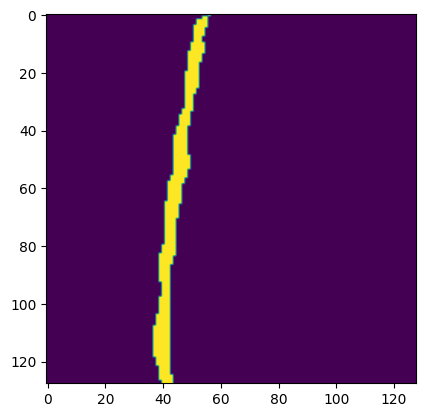

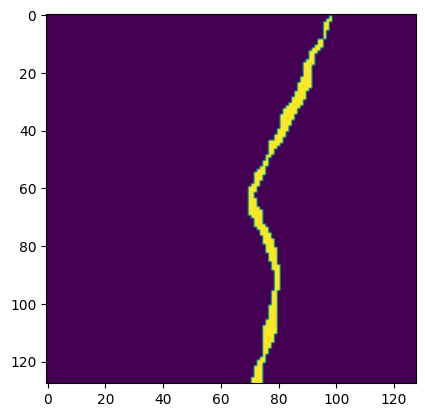

In [156]:
# Label the connected components
masks = separate_mask(mask)
print(f"Found {len(masks)} connected components")
for separated_mask in masks:
    show_mask(separated_mask)


DEBUG: mask (ndarray: uint8) = [[0, 0, 0, 0, 0, 0, 0, 0, ....], ...] (128, 128)
DEBUG: mask_tensor (Tensor: float32) = [[[....]] (1, 128, 128) (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)


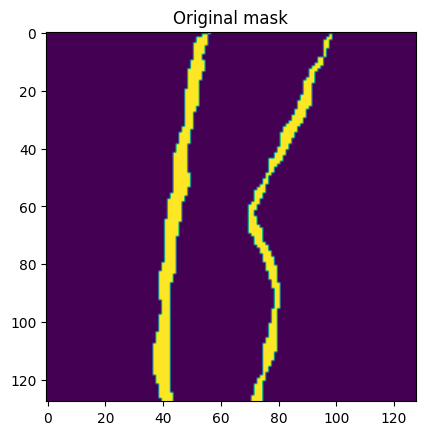

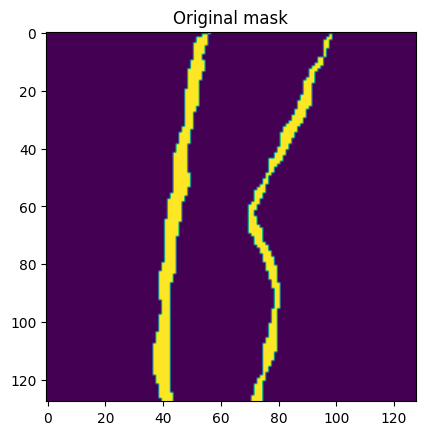

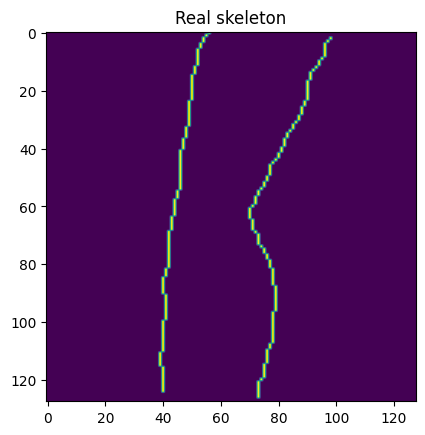

DEBUG: soft_skeleton (Tensor: bool) = [[....], ...] (128, 128) (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)


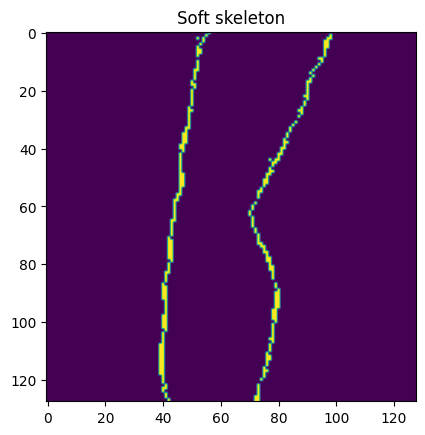

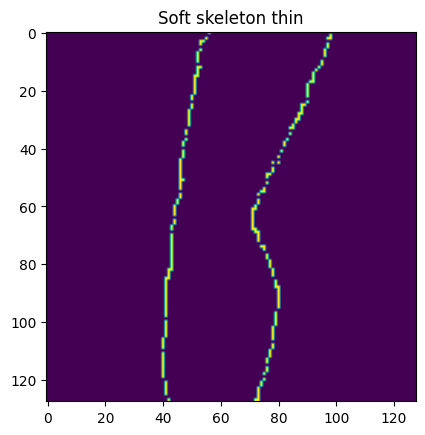

In [190]:
# Show the different version of the skeletonization
debug(mask)
real_skeleton = skeletonize(mask, method='lee') # https://stackoverflow.com/questions/56394869/how-to-estimate-piece-wise-smooth-fit-to-a-noisy-mask
mask_tensor = torch.from_numpy(mask).float().unsqueeze(0)
debug(mask_tensor)
soft_skeleton = soft_skeletonize(mask_tensor, 5).squeeze(0).squeeze(0) > 0.5
soft_skeleton_thin = soft_skeletonize_thin(mask_tensor, 10).squeeze(0) > 0.5

# Show original mask
show_mask(mask_tensor.squeeze(0).squeeze(0), "Original mask")
show_mask(mask, "Original mask")
show_mask(real_skeleton, "Real skeleton")
debug(soft_skeleton)
show_mask(soft_skeleton, "Soft skeleton")
show_mask(soft_skeleton_thin, "Soft skeleton thin")

DEBUG: input_tensor (Tensor: float32) = [[[...]] (1, 128, 128) (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: soft_skeleton_thin (Tensor: float32) = [] (1, 128, 128) (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: mask_wide (Tensor: float32) = [[[0.0...]] (1, 128, 128) (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: mask_wide.max( (Tensor: float32) = 1.0 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: mask_wide.min( (Tensor: float32) = 7.7809243...5e-05 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)


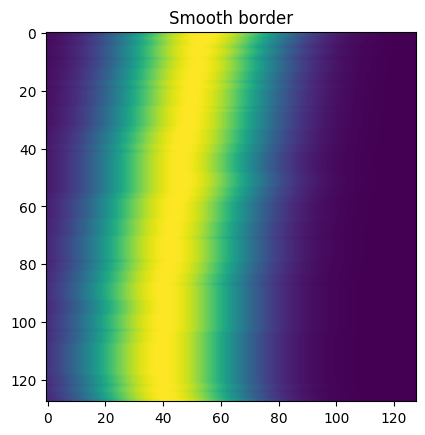

DEBUG: skeleton_wide (Tensor: float32) = [[...]] (1, 128, 128) (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: skeleton_wide.max( (Tensor: float32) = 0.625...61908 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: skeleton_wide.min( (Tensor: float32) = 0.0 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)


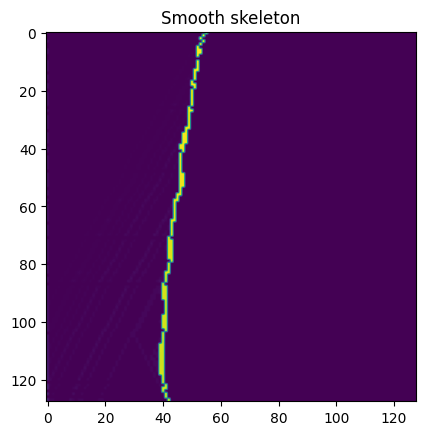

In [177]:
input_tensor = mask_tensor.float().squeeze(0)
debug(input_tensor)
soft_skeleton_thin = soft_skeletonize(input_tensor, 10)
debug(soft_skeleton_thin)
mask_wide = add_smooth_border_to_mask(soft_skeleton_thin, 128, 20.0)
debug(mask_wide)
debug(mask_wide.max())
debug(mask_wide.min())
show_mask(mask_wide.squeeze(0), "Smooth border")
skeleton_wide = soft_skeletonize(mask_wide, 128)
debug(skeleton_wide)
debug(skeleton_wide.max())
debug(skeleton_wide.min())
show_mask(skeleton_wide.squeeze(0), "Smooth skeleton")

In [45]:
def show_masks(masks: List[np.ndarray], colors: Optional[List[List[int]]] = None):
    # Plots a list of masks in different colors
    if colors is None:
        colors = [[255,255,255], [255, 0, 0], [0, 255, 0], [0, 0, 255]]
    assert len(masks) <= len(colors), "Not enough colors to plot the masks"

    # Create a black image
    img = np.zeros((masks[0].shape[0], masks[0].shape[1], 3), np.uint8)
    for i, mask in enumerate(masks):
        img[mask == 1] = colors[i]
    plt.imshow(img)
    plt.show()

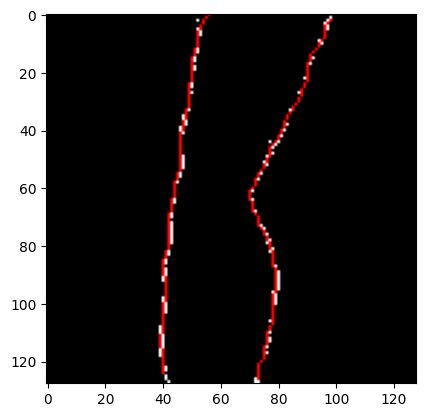

In [46]:
show_masks([(skeleton2.squeeze(0) > 0.5).numpy(), skeleton])

In [47]:
mask_tensor = torch.from_numpy(masks[0]).unsqueeze(0).unsqueeze(0).float()

In [48]:
# Into dense
contours, _ = cv2.findContours(skeleton, 0,cv2.CHAIN_APPROX_NONE)
arch = contours[0]
x,y = arch[...,0].squeeze(), arch[...,1].squeeze()

# Fitting a curve
xx, yy = x[0::15], y[0::15] #<- sample every 15th element to see that the interpolate really works
f = interp1d(xx, yy)

/media/jsomerviller/SSD2/anaconda3/envs/reachbot/lib/python3.8/site-packages/skimage/util/dtype.py:550: UserWarning: Downcasting int64 to uint8 without scaling because max value 1 fits in uint8
  return _convert(image, np.uint8, force_copy)
/media/jsomerviller/SSD2/anaconda3/envs/reachbot/lib/python3.8/site-packages/scipy/interpolate/_interpolate.py:698: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
/media/jsomerviller/SSD2/anaconda3/envs/reachbot/lib/python3.8/site-packages/scipy/interpolate/_interpolate.py:701: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


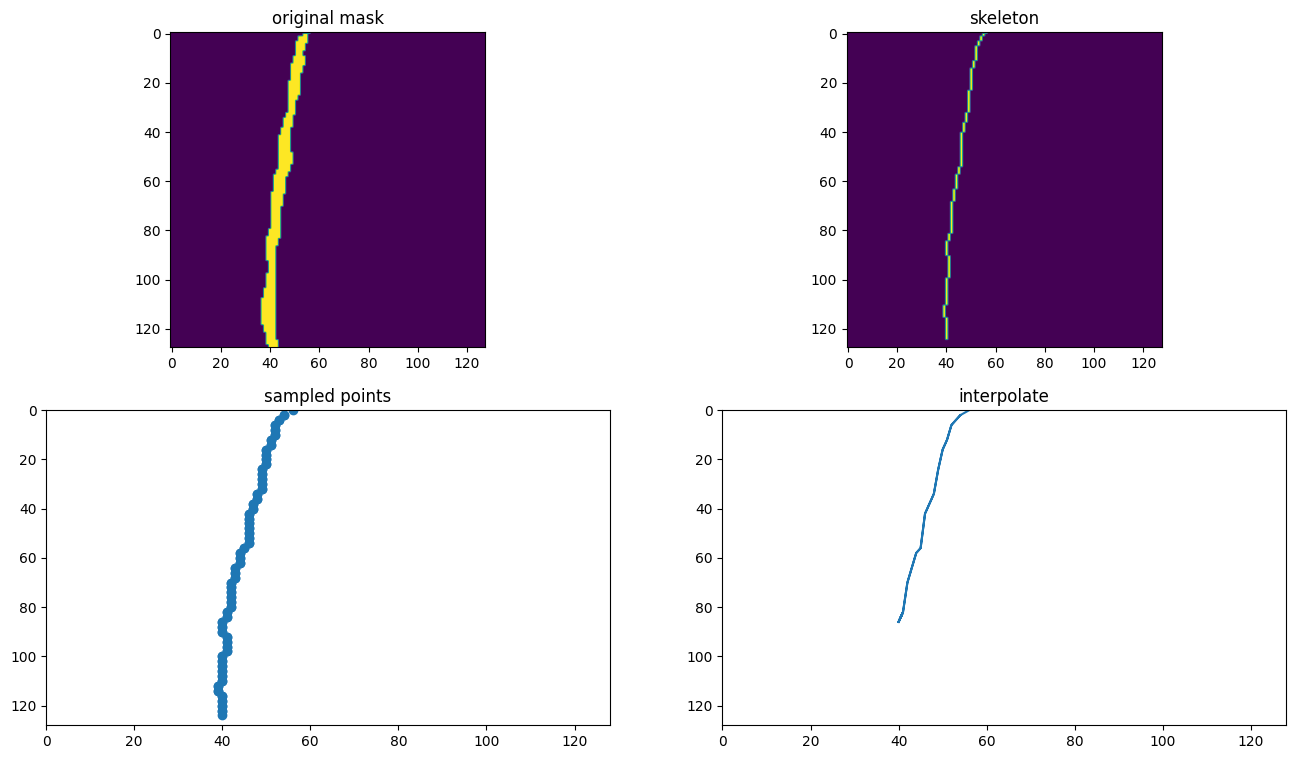

In [49]:
from skimage.morphology import skeletonize
import matplotlib.pyplot as plt
import cv2
import numpy as np
from scipy.interpolate import interp1d

#img = cv2.imread("./data/bAiew.png", 0)
#img = cv2.medianBlur(masks[0], 11)
#img = img//255
img = masks[0]

# Sparse skeleton
skeleton = skeletonize(img, method='lee')

# Into dense
contours, _ = cv2.findContours(skeleton, 0,cv2.CHAIN_APPROX_NONE)
arch = contours[0]
x,y = arch[...,0].squeeze(), arch[...,1].squeeze()

# Fitting a curve
xx, yy = x[0::2], y[0::2] #<- sample every 15th element to see that the interpolate really works
f = interp1d(xx, yy)

plt.figure(figsize=(16,9))
plt.subplot(221)
plt.imshow(img)
plt.title('original mask')

plt.subplot(222)
plt.imshow(skeleton)
plt.title('skeleton')

plt.subplot(223)
plt.scatter(xx,yy)
plt.ylim([img.shape[0],0])
plt.xlim([0, img.shape[1]])
plt.title('sampled points')

plt.subplot(224)
plt.plot(xx,f(xx))
plt.ylim([img.shape[0],0])
plt.xlim([0, img.shape[1]])
plt.title('interpolate')
plt.show()

In [50]:
def to_np(image: Union[np.ndarray, Image.Image], dtype: np.dtype = np.float32) -> np.ndarray:
    """
    Converts a PIL image, a numpy array or a PyTorch tensor to a numpy array.
    Converts to an array from 0 to 1 by default.
    The output shape is (height, width, channels).

    Args:
        image: The image to convert.

    Returns:
        The converted image.
    """
    if isinstance(image, Image.Image):
        image = np.array(image)
    elif not isinstance(image, np.ndarray):
        raise ValueError(
            f"Expected image to be a PIL image, a numpy array or a PyTorch "
            f"tensor. Got {type(image)}."
        )

    if image.dtype == np.uint8 and np.max(image) > 1:
        image = image.astype(np.float32) / 255.0

    if image.dtype != dtype:
        # Secial case for binary images. Uses a threshold to prevent rounding errors
        if dtype == bool:
            image = image > 0.5
        else:
            image = image.astype(dtype)

    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)

    return image

In [51]:
def preprocess_for_comparison(
    ground_truth: Union[np.ndarray, Image.Image],
    prediction: Union[np.ndarray, Image.Image],
    dtype: np.dtype = np.float32,
    diffuse_sigma_factor: float = 0.0) -> Tuple[np.ndarray, np.ndarray]:
    """
    Preprocesses the ground truth and the prediction for comparison.
    Returns both images as numpy arrays of type np.float32 (from 0 to 1).
    Check that the shapes are the same.
    """
    ground_truth = to_np(ground_truth, dtype=dtype)
    prediction = to_np(prediction, dtype=dtype)
    assert ground_truth.shape == prediction.shape, \
        f"Expected ground truth and prediction to have the same shape. " \
        f"Got {ground_truth.shape} and {prediction.shape}."
    
    # Applies a gaussian diffusion to the images
    if diffuse_sigma_factor > 0:
        assert dtype == np.float32, \
            f"Expected dtype to be np.float32 when using a gaussian diffusion. " \
            f"Got {dtype}."
        ground_truth = apply_gaussian_diffusion(ground_truth, diffuse_sigma_factor)
        prediction = apply_gaussian_diffusion(prediction, diffuse_sigma_factor)

    return ground_truth, prediction

In [52]:
def get_bounding_box(mask) -> Tuple[int, int, int, int]:
    """
    Returns the bounding box of a binary mask.
    The bounding box is defined as (x_min, y_min, x_max, y_max).
    """
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)
    x_min, x_max = np.where(cols)[0][[0, -1]]
    y_min, y_max = np.where(rows)[0][[0, -1]]
    return x_min, y_min, x_max, y_max

def crop_to_bounding_box(
    image: Union[np.ndarray, Image.Image],
    bounding_box: Tuple[int, int, int, int]) -> Union[np.ndarray, Image.Image]:
    """
    Crops an image to a bounding box.
    The bounding box is defined as (x_min, y_min, x_max, y_max).
    """
    if isinstance(image, Image.Image):
        return image.crop(bounding_box)
    else:
        return image[bounding_box[1]:bounding_box[3], bounding_box[0]:bounding_box[2]]

def get_shared_bounding_box(mask1, mask2) -> Tuple[int, int, int, int]:
    """
    Returns the smallest bounding box such that boths masks are contained in it."""
    x_min1, y_min1, x_max1, y_max1 = get_bounding_box(mask1)
    x_min2, y_min2, x_max2, y_max2 = get_bounding_box(mask2)
    x_min = min(x_min1, x_min2)
    y_min = min(y_min1, y_min2)
    x_max = max(x_max1, x_max2)
    y_max = max(y_max1, y_max2)
    return x_min, y_min, x_max, y_max

def crop_as_small_as_possible(mask1, mask2):
    """Crop both masks to their shared bounding box."""
    x_min, y_min, x_max, y_max = get_shared_bounding_box(mask1, mask2)
    mask1 = crop_to_bounding_box(mask1, (x_min, y_min, x_max, y_max))
    mask2 = crop_to_bounding_box(mask2, (x_min, y_min, x_max, y_max))
    return mask1, mask2

In [60]:
def crack_metrics(
    ground_truth: Union[np.ndarray, Image.Image],
    prediction: Union[np.ndarray, Image.Image],
    sigma_factor: float = 0.1,
    crop: bool = True) -> Dict[str, float]:
    ground_truth, prediction = preprocess_for_comparison(ground_truth, prediction, dtype=bool)
    sigma = sigma_factor * np.sqrt(ground_truth.shape[0] * ground_truth.shape[1])
    if crop: ground_truth, prediction = crop_as_small_as_possible(ground_truth, prediction)
    num_pixels_gt = np.sum(ground_truth)
    num_pixels_pred = np.sum(prediction)

    # Skeletonizes the ground truth and the prediction
    # First crop the images as small as possible to speed up the computation
    skeleton_gt = skeletonize(ground_truth, method='lee')
    skeleton_pred = skeletonize(prediction, method='lee')
    lenght_gt = np.sum(skeleton_gt)
    length_pred = np.sum(skeleton_pred)

    # Computes the ratio of length
    length_ratio = np.exp(- 1.0 * np.abs(lenght_gt.astype(float) - length_pred) / lenght_gt) 

    # Computes the distance between the two skeletons
    if lenght_gt == 0 and length_pred == 0:
        line_distance_score = 1.
    elif lenght_gt == 0 or length_pred == 0:
        line_distance_score = 0.
    else:
        distances_gt = scipy.ndimage.distance_transform_edt(skeleton_gt == 0)
        distances_pred = scipy.ndimage.distance_transform_edt(skeleton_pred == 0)
        distance_factor_gt = np.sum(skeleton_pred * np.exp(-distances_gt ** 2 / (2 * sigma ** 2))) / lenght_gt
        distance_factor_pred = np.sum(skeleton_gt * np.exp(-distances_pred ** 2 / (2 * sigma ** 2))) / length_pred
        line_distance_score = distance_factor_gt * distance_factor_pred

    # Computes the width score
    # A simple approximation is simply the ratio of the number of pixels
    # To decorelate this from the length score
    width_ratio = num_pixels_gt * length_pred / (num_pixels_pred * lenght_gt)
    width_ratio = np.exp( - np.abs(1 - width_ratio))

    # Intersection and union
    intersection = np.sum(np.logical_and(ground_truth, prediction))
    union = np.sum(np.logical_or(ground_truth, prediction))
    iou = intersection / union
    dice = 2 * intersection / (intersection + union)


    results = {
        'length': length_ratio,
        'line_distance': line_distance_score,
        'width': width_ratio,
        'iou': iou,
        'dice': dice
    }
    return results

if we double the scale, then:
- $d = \sqrt{x^2 + y^2}$ becomes $d' = \sqrt{(2x)^2 + (2y)^2} = 2d$
- $\sigma$ also doubles so we are good

In [178]:
def generate_prediction(mask, movement=1, scale=1, noise=1):
    prediction = mask.copy()
    # Introduce random translation, rotation and even scaling (small amount)
    prediction = scipy.ndimage.rotate(prediction, np.random.uniform(-10*movement, 10*movement), reshape=False)
    prediction = scipy.ndimage.shift(prediction, np.random.uniform(-10*movement, 10*movement, size=2))
    # Zoom but keep the same size
    prediction = scipy.ndimage.zoom(prediction, np.random.uniform(1-0.1*scale, 1+0.1*scale))
    # If the image is too big, crop it
    if prediction.shape[0] > mask.shape[0] or prediction.shape[1] > mask.shape[1]:
        prediction = prediction[:mask.shape[0], :mask.shape[1]]
    # If the image is too small, pad it
    if prediction.shape[0] < mask.shape[0] or prediction.shape[1] < mask.shape[1]:
        prediction = np.pad(prediction, ((0, mask.shape[0]-prediction.shape[0]), (0, mask.shape[1]-prediction.shape[1])), mode='constant')
    # Add noise
    prediction = prediction + np.abs(np.random.normal(0, 0.7 * noise, prediction.shape)) / (1+scipy.ndimage.distance_transform_edt(prediction <= 0.5))**2
    prediction = prediction >= 0.5
    return prediction

In [179]:
prediction = generate_prediction(masks[1], movement=3.0, scale=0, noise = 0)

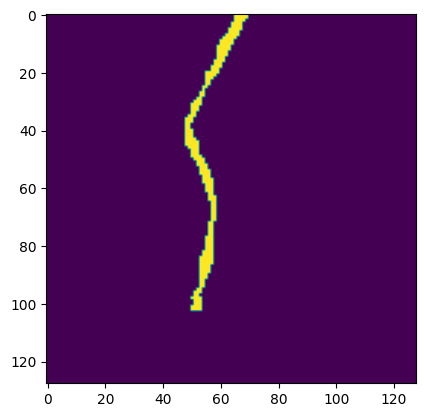

In [180]:
show_mask(prediction)

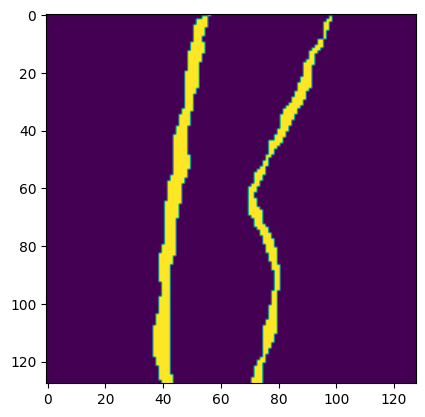

In [181]:
show_mask(mask)

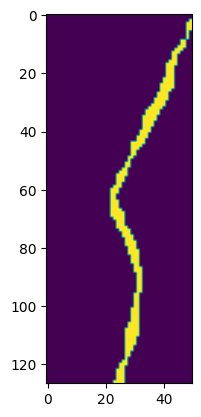

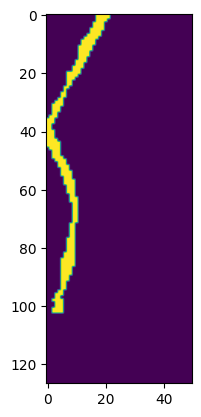

In [182]:
mask_cropped, pred_cropped = crop_as_small_as_possible(masks[1], prediction)
show_mask(mask_cropped)
show_mask(pred_cropped)

In [183]:
pred = torch.from_numpy(prediction).unsqueeze(0).float()
pred.requires_grad = True
debug(pred)
gt = torch.from_numpy(masks[1]).unsqueeze(0).float()
gt.requires_grad = True
debug(gt)
print("smooth_skeleton_intersection_loss:",
    smooth_skeleton_intersection_loss(gt, pred, iterations=10, border_size=25, sigma=10.0, thinner=False, epsilon=1e-6)
)
print("smooth_skeleton_dice_loss:",
    smooth_skeleton_dice_loss(gt, pred, iterations=10, border_size=25, sigma=10.0, thinner=False)
)


DEBUG: pred (Tensor: float32) = [[[.....], ...]] (1, 128, 128) (cpu) (req-grad)
DEBUG: gt (Tensor: float32) = [[[...0...], ...]] (1, 128, 128) (cpu) (req-grad)
smooth_skeleton_intersection_loss: tensor([0.9264], grad_fn=<RsubBackward1>)
smooth_skeleton_dice_loss: tensor([0.7977], grad_fn=<RsubBackward1>)


In [66]:
crack_metrics(masks[1], prediction)

{'length': 0.937029371978316,
 'line_distance': 0.20275582208712015,
 'width': 0.9347799314045695,
 'iou': 0.037383177570093455,
 'dice': 0.07207207207207207}

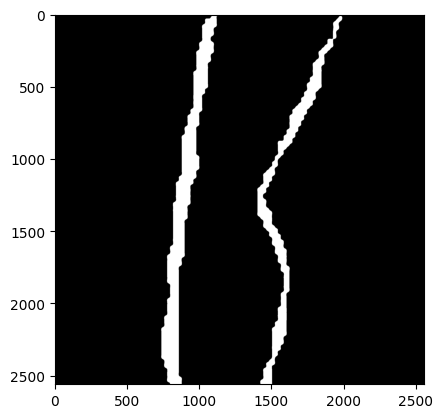

0.4934663572744836

In [ ]:
# Scaleb by two the mask and checks that we get the same result
mask_2x = scipy.ndimage.zoom(mask, 20)
show_mask(mask_2x)
predicion_2x = scipy.ndimage.zoom(prediction, 20)
binary_distance_proximity(skeletonize(mask_2x, method='lee'), skeletonize(predicion_2x, method='lee'))

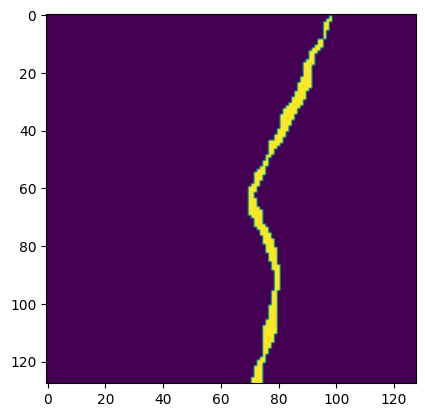

DEBUG: out (Tensor: float32) = [[0.0, ......], ...] (128, 128) (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: out.max( (Tensor: float32) = 3.1415927410125732 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)
DEBUG: out.min( (Tensor: float32) = 0.0 () (cpu) (̶r̶e̶q̶-̶g̶r̶a̶d)


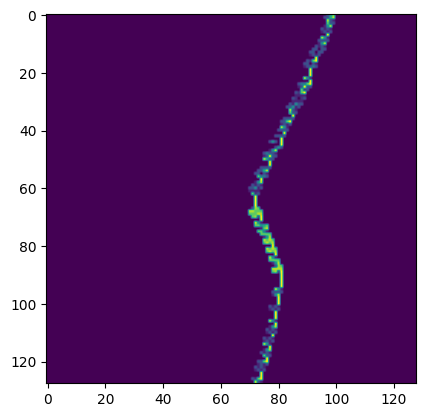

In [145]:
def compute_direction_of_mask(mask: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    """Given a mask, computes the direction of the mask in each pixel.
    
    Args:
        mask: Input mask (shape: (N, H, W) or (H, W)).
        
    Returns:
        direction_x: Direction of the mask in the x direction (shape: (N, H, W) or (H, W)).
        direction_y: Direction of the mask in the y direction (shape: (N, H, W) or (H, W)).
    """

    # Computes the gradient of the mask
    mask = mask.float()
    mask = soft_skeletonize_thin(mask, 10)
     # Sobel operator
    kernel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    kernel_y = torch.tensor([[-1, -2, -1], [0, 0, 0], [1, 2, 1]], dtype=torch.float32).unsqueeze(0).unsqueeze(0)
    gradient_x = F.conv2d(mask.unsqueeze(0), kernel_x, padding=1).squeeze(0)
    gradient_y = F.conv2d(mask.unsqueeze(0), kernel_y, padding=1).squeeze(0)
    angle = torch.atan2(gradient_y, gradient_x)
    angle[angle < 0] += np.pi
    #angle = soft_skeletonize_thin(angle, 10)
    return angle
    debug(gradient)
    return gradient

    # Computes the direction of the mask
    direction_x = torch.where(mask == 1, gradient[:, :, :, 0], 0)
    direction_y = torch.where(mask == 1, gradient[:, :, :, 1], 0)
    return direction_x, direction_y

# Test the function
show_mask(masks[1])
out = compute_direction_of_mask(torch.from_numpy(masks[1]).unsqueeze(0)) 
out = out.squeeze(0)# / torch.max(out)
debug(out)
debug(out.max())
debug(out.min())
show_mask(out)